In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv
import math

In [3]:
class Location:
    def __init__(self, name=None, distance=None):
        self.name = name
        self.distance = distance

In [4]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance, p, counter, boat_list, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        #self.location.distance = distance[' '.join(self.location.name)]
        self.location.distance = distance[self.location.name]

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        #print('%7.4f Call %d received from %s at a distance of %d' % (env.now, self.ID, self.location.name, self.location.distance))
        
        with counter.request() as req:
            yield req
            wait = env.now - self.initial_time #waiting time 
            #print('%7.4f Call %d: Waited %6.3f' % (env.now, self.ID, wait))
            yield env.process(trajet(env, boat_list, self, wait))
            #print('%7.4f Call %d: Finished' % (env.now, self.ID))

        self.status = 1
        

In [5]:
def trajet(env, boat_list, call, wait): 
    i = 0 
    while(i != len(boat_list) and boat_list[i].status != 0): #while you don't have a boat available 
        i = i + 1
    if(i != len(boat_list) and boat_list[i].status == 0): #if you have a boat available
        boat_list[i].status = 1 
        intervention = Intervention()
        #print('Boat {} with a speed of {} respond to the call {} '.format(boat_list[i].ID, boat_list[i].speed, call.ID))
        intervention.boat = boat_list[i]
        intervention.call = call
        intervention.travel_time = call.location.distance/boat_list[i].speed
        intervention.TOS = 0.25
        intervention.waited_time = wait 
        intervention.response_time = intervention.travel_time + wait 
        intervention.road_time = 2*intervention.travel_time + intervention.TOS 
        inter_list.append(intervention)
        yield env.timeout(intervention.road_time)
        call.final_time = call.initial_time + intervention.road_time 
        #print('Duration of the intervention {} : {} '.format(intervention.ID, intervention.road_time))
        boat_list[i].status = 0
    

In [6]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat = boat
        self.call = call
        
    def to_dict(self): 
        return {
            'ID intervention': self.ID,
            'Boat associated': self.boat.ID,
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'Time On Scene': self.TOS,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [7]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 

In [8]:
def source(env, counter, p, boat_list, call_list, coeff_call): 
    yield env.timeout(0)
    #print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance, p, counter, boat_list))
        else: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance, p, counter, boat_list, call_list[i-1]))

In [9]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':100, 'N SRA P. SOCORRO':90, 'BONSUCESSO':80, 'ASS. NAZARE':70, 'GUAJARA':60, 
            'ARUAU':100, 'MIPINDIAU':90, 'CUIEIRAS':75, 'SANTA MARIA':60, 'JARAQUI':52, 'COSTA DOS ARARAS':50, 
            'COSTA DO TATU':30, 'AGROVILA':20, 'N. SRA. FATIMA':15, 'LIVRAMENTO':15}

nb_boat = 3
nb_call = 164
nb_repet = 100
inter_list = []
df = []
call_list = []
interval = []
test = []

In [10]:
#Setup and lauch of the simulation 
def model(nb_boat, coeff, speed):
    env = simpy.Environment()
    boat_list = []
    for i in range(nb_boat): 
        boat_list.append(Boat(env,speed,0))
    counter = simpy.Resource(env, capacity=nb_boat)
    env.process(source(env, counter, p_2015, boat_list, call_list, coeff))
    env.run()

In [11]:
#Allow to launch nb_repet of repetitions fixing the seed 
#variation of the lambda and of the number of boats 
coeff_call_list = [(i*2) for i in range(2, 20)]
speed = 46
for i in range(1, nb_boat+1): 
    j = 0 
    for coeff in coeff_call_list: 
        random.seed(42)
        np.random.seed(42)
        model(i, coeff, speed)
        df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
        interval.append(df[j]["waited time"].mean())
        
        print("lambda: {} temps d'attente moyen: {} with {}".format(coeff, df[j]["waited time"].mean(), i))
        #reset the global variables 
        inter_list = []
        call_list = []
        j = j + 1 
        
    test.append(interval)
    interval = []
    df = []

lambda: 4 temps d'attente moyen: 4.205785042037129 with 1
lambda: 6 temps d'attente moyen: 1.637475858313145 with 1
lambda: 8 temps d'attente moyen: 0.9283509303190175 with 1
lambda: 10 temps d'attente moyen: 0.644730524522888 with 1
lambda: 12 temps d'attente moyen: 0.4803013409759215 with 1
lambda: 14 temps d'attente moyen: 0.3748366967423893 with 1
lambda: 16 temps d'attente moyen: 0.2996992247578285 with 1
lambda: 18 temps d'attente moyen: 0.24335732003456495 with 1
lambda: 20 temps d'attente moyen: 0.20896749367590145 with 1
lambda: 22 temps d'attente moyen: 0.18415372983376319 with 1
lambda: 24 temps d'attente moyen: 0.16548495006131872 with 1
lambda: 26 temps d'attente moyen: 0.14761450633489537 with 1
lambda: 28 temps d'attente moyen: 0.13381042562489762 with 1
lambda: 30 temps d'attente moyen: 0.12380254406987767 with 1
lambda: 32 temps d'attente moyen: 0.1142980052970097 with 1
lambda: 34 temps d'attente moyen: 0.10491077754406007 with 1
lambda: 36 temps d'attente moyen: 0.09

In [12]:
#Allow to launch nb_repet of repetitions for each lambda 
#variation of the lambda and of the number of boats 
coeff_call_list = [(i*2) for i in range(2, 20)]
speed = 46
inter = []
result = []
for i in range(1, nb_boat+1): 
    for coeff in coeff_call_list: 
        for j in range(nb_repet):
            model(i, coeff, speed)
            df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
            interval.append(df[j]["waited time"].mean())
            inter_list = []
            call_list = []
        inter.append(sum(interval)/len(interval))
        print("lambda: {} temps d'attente moyen: {} with {} boat(s)".format(coeff, sum(interval)/len(interval), i)) 
        interval = []
        df = []
    result.append(inter)
    inter = []

lambda: 4 temps d'attente moyen: 3.640542112578434 with 1 boat(s)
lambda: 6 temps d'attente moyen: 1.4037692535296145 with 1 boat(s)
lambda: 8 temps d'attente moyen: 0.9334075427342454 with 1 boat(s)
lambda: 10 temps d'attente moyen: 0.64851920998218 with 1 boat(s)
lambda: 12 temps d'attente moyen: 0.4880104285522248 with 1 boat(s)
lambda: 14 temps d'attente moyen: 0.4370042099321114 with 1 boat(s)
lambda: 16 temps d'attente moyen: 0.3666721144918564 with 1 boat(s)
lambda: 18 temps d'attente moyen: 0.3072753403590247 with 1 boat(s)
lambda: 20 temps d'attente moyen: 0.2600955748130461 with 1 boat(s)
lambda: 22 temps d'attente moyen: 0.23145547708628633 with 1 boat(s)
lambda: 24 temps d'attente moyen: 0.22066127474844066 with 1 boat(s)
lambda: 26 temps d'attente moyen: 0.20139524236729922 with 1 boat(s)
lambda: 28 temps d'attente moyen: 0.1930454356766964 with 1 boat(s)
lambda: 30 temps d'attente moyen: 0.16461293347049064 with 1 boat(s)
lambda: 32 temps d'attente moyen: 0.16473927816287

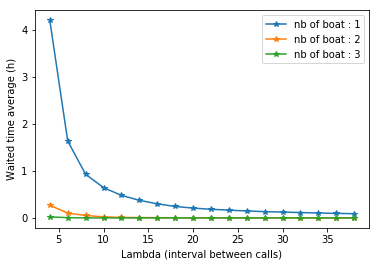

In [13]:
#Result of the first set of simulations 
for i in range(nb_boat): 
    plt.plot(coeff_call_list, test[i], marker='*', label="nb of boat : {}".format(i+1))
plt.legend(loc="upper right")
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Waited time average (h)')
plt.show()

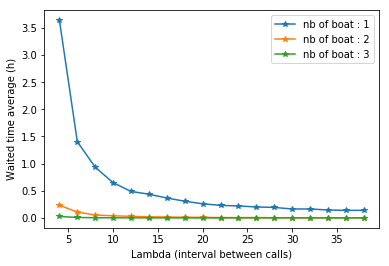

In [14]:
#Result of the second set of simulations 
for i in range(nb_boat): 
    plt.plot(coeff_call_list, result[i], marker='*', label="nb of boat : {}".format(i+1))
plt.legend(loc="upper right")
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Waited time average (h)')
plt.show()

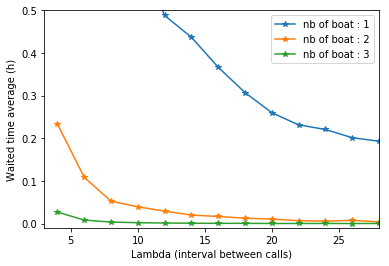

In [15]:
#Zoom of the second set of simulations 
for i in range(nb_boat): 
    plt.plot(coeff_call_list, result[i], marker='*', label="nb of boat : {}".format(i+1))
axes = plt.gca()
plt.legend(loc="upper right")
axes.set_xlim(3, 28)
axes.set_ylim(-0.01, 0.5)
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Waited time average (h)')
plt.show()

In [16]:
#Variation of the speed of the boat 
#Impact on the intervention time 
speed_list = [i*5 for i in range(1,18)]
coeff = 38
j = 0 
df = []
interval = []
for i in speed_list:
    random.seed(42)
    np.random.seed(42)
    model(1, coeff, i)
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
    interval.append(df[j]["total time"].mean())
        
    print("lambda: {} temps d'intervention total moyen: {} speed:{}".format(coeff, df[j]["total time"].mean(), i))
    #reset the global variables 
    inter_list = []
    call_list = []
    j = j + 1 
    

lambda: 38 temps d'intervention total moyen: 24.857317073170734 speed:5
lambda: 38 temps d'intervention total moyen: 12.553658536585367 speed:10
lambda: 38 temps d'intervention total moyen: 8.452439024390241 speed:15
lambda: 38 temps d'intervention total moyen: 6.401829268292683 speed:20
lambda: 38 temps d'intervention total moyen: 5.171463414634146 speed:25
lambda: 38 temps d'intervention total moyen: 4.3512195121951205 speed:30
lambda: 38 temps d'intervention total moyen: 3.7653310104529605 speed:35
lambda: 38 temps d'intervention total moyen: 3.3259146341463417 speed:40
lambda: 38 temps d'intervention total moyen: 2.984146341463419 speed:45
lambda: 38 temps d'intervention total moyen: 2.7107317073170734 speed:50
lambda: 38 temps d'intervention total moyen: 2.487028824833702 speed:55
lambda: 38 temps d'intervention total moyen: 2.30060975609756 speed:60
lambda: 38 temps d'intervention total moyen: 2.1428705440900577 speed:65
lambda: 38 temps d'intervention total moyen: 2.007665505226

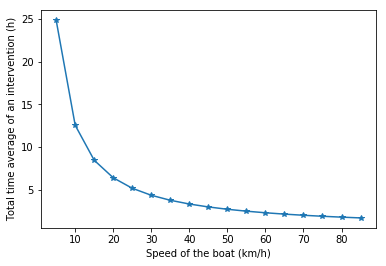

In [17]:
#Result of the variation of the speed of the boat on the intervention time 
plt.plot(speed_list, interval, marker='*')
plt.xlabel('Speed of the boat (km/h)')
plt.ylabel('Total time average of an intervention (h)')
plt.show()

In [18]:
#Variation of the speed of the boat 
#Impact on the waited time 
speed_list = [i*5 for i in range(2,18)]
coeff = 38
j = 0 
df = []
interval = []
for i in speed_list:
    random.seed(42)
    np.random.seed(42)
    model(1, coeff, i)
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
    interval.append(df[j]["waited time"].mean())
        
    print("lambda: {} temps d'attente moyen: {} speed:{}".format(coeff, df[j]["waited time"].mean(), i))
    #reset the global variables 
    inter_list = []
    call_list = []
    j = j + 1 

lambda: 38 temps d'attente moyen: 3.4230923842528265 speed:10
lambda: 38 temps d'attente moyen: 1.2091879454906174 speed:15
lambda: 38 temps d'attente moyen: 0.5740402867450466 speed:20
lambda: 38 temps d'attente moyen: 0.33505678040316256 speed:25
lambda: 38 temps d'attente moyen: 0.2252753712920347 speed:30
lambda: 38 temps d'attente moyen: 0.16327264833308713 speed:35
lambda: 38 temps d'attente moyen: 0.12282056024309826 speed:40
lambda: 38 temps d'attente moyen: 0.09418102943354881 speed:45
lambda: 38 temps d'attente moyen: 0.07783098592049363 speed:50
lambda: 38 temps d'attente moyen: 0.06532147369231935 speed:55
lambda: 38 temps d'attente moyen: 0.05672945595395791 speed:60
lambda: 38 temps d'attente moyen: 0.049459287098420505 speed:65
lambda: 38 temps d'attente moyen: 0.043227713793678076 speed:70
lambda: 38 temps d'attente moyen: 0.0379941897842179 speed:75
lambda: 38 temps d'attente moyen: 0.0342848401907236 speed:80
lambda: 38 temps d'attente moyen: 0.031011884667050918 spee

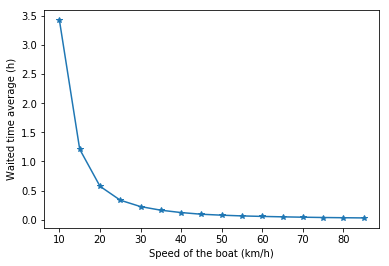

In [19]:
#Result of the variation of the speed of the boat on the waited time 
plt.plot(speed_list, interval, marker='*')
plt.xlabel('Speed of the boat (km/h)')
plt.ylabel('Waited time average (h)')
plt.show()